# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

# Import Libraries

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from astral import LocationInfo
from astral.sun import sun
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from pycaret.regression import *
from math import sqrt

# Creating decoders

In [2]:
def code_to_season(code):
    if code == 1:
        return "Spring"
    elif code == 2:
        return "Summer"
    elif code == 3:
        return "Fall"
    else:
        return "Winter"

def code_to_weather(code):
    if code == 1:
        return "Clear"
    elif code == 2:
        return "Mist"
    elif code == 3:
        return "Light Snow"
    else:
        return "Heavy Rain"

def calculate_daylight_hours(date):
    d = date
    try:
        city = LocationInfo("Washington", "USA", "US/Eastern", 38.9072, -77.0369)
        s = sun(city.observer, date=d)
        daylight_hours = (s['sunset'] - s['sunrise']).seconds / 3600
        return daylight_hours
    except Exception as e:
        return None

def daylight_fill_nulls(data_input):
    bike_data_copy = data_input.copy()
    median_daylight_by_season = bike_data_copy.groupby('season')['daylight_hours'].median()
    bike_data_copy['daylight_hours'] = bike_data_copy.apply(
        lambda row: median_daylight_by_season[row['season']] if pd.isnull(row['daylight_hours']) else row['daylight_hours'],
        axis=1
    )
    return  bike_data_copy

def data_fill_empty_by_season_median(data_input, category):
    bike_data_copy = data_input.copy()
    median_by_season = bike_data_copy.groupby('season')[category].median()
    bike_data_copy[category] = bike_data_copy.apply(
        lambda row: median_by_season[row['season']] if row[category] == 0 else row[category],
        axis=1
    )
    return bike_data_copy

In [ ]:
data = pd.read_csv("bike-sharing_hourly.csv")
data

# Ensuring data quality (correctness, consistency, missing values, outliers...).

In [ ]:
bike_data = data.copy()

In [ ]:
data_types = bike_data.dtypes
data_types

In [ ]:
duplicate_rows = bike_data.duplicated().sum()
duplicate_rows

In [ ]:
missing_values = bike_data.isnull().sum()
missing_values

In [ ]:
summary_statistics = bike_data.describe()
summary_statistics

In [ ]:
bike_data['dteday'] = pd.to_datetime(bike_data['dteday'])
bike_data['dteday'].dtype

# Plotting box plot for continuos variables

In [ ]:
# Plotting boxplots for continuous variables
plt.figure(figsize=(15, 10))

# Subplot for 'temp'
plt.subplot(2, 2, 1)
sns.boxplot(x=bike_data['temp'])
plt.title('Boxplot of Temperature')

# Subplot for 'atemp'
plt.subplot(2, 2, 2)
sns.boxplot(x=bike_data['atemp'])
plt.title('Boxplot of "Feels Like" Temperature')

# Subplot for 'hum'
plt.subplot(2, 2, 3)
sns.boxplot(x=bike_data['hum'])
plt.title('Boxplot of Humidity')

# Subplot for 'windspeed'
plt.subplot(2, 2, 4)
sns.boxplot(x=bike_data['windspeed'])
plt.title('Boxplot of Wind Speed')

plt.tight_layout()
plt.show()

# hum -> Some ceros, maybe an error of the sensor
# windspeed -> Several outliers ; RobustScaler is recommended

In [ ]:
# Plot data without enconding
data_corr = bike_data.drop(columns=["instant","dteday", "casual", "registered", "cnt"])
plt.figure(figsize=(12, 10))
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Bike Rental Dataset')
plt.show()

# High correlations
# season --> mnth
# temp --> atemp

# Adding daylight hours

In [ ]:
bike_data['daylight_hours'] = bike_data['dteday'].dt.date.apply(calculate_daylight_hours)
bike_data.isnull().sum()

In [ ]:
# Calculate the median daylight hours for each season
bike_data = daylight_fill_nulls(bike_data)

In [ ]:
bike_data.isnull().sum()

# Run Correlation Again

In [ ]:
# Plot data without enconding
data_corr = bike_data.drop(columns=["instant","dteday", "casual", "registered", "cnt"])
plt.figure(figsize=(12, 10))
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Bike Rental Dataset')
plt.show()

# High correlations
# season --> mnth
# temp --> atemp

# Giving insights on what seems relevant for prediction and what does not.
## Notes
- No missing values
- hum -> Some ceros, maybe an error of the sensor
- windspeed -> Several outliers 
- High correlations
-- season <--> mnth
-- temp <--> atemp
-- daylight_hours does not have high correlations
## Decisions
-- RobustScaler is recommended because there are outliers
-- Use season instead mnth and year
-- Remove instant, dtedat, year and mnth because data is independent of the date
-- Remove atemp

# Decoding variables

In [ ]:
bike_data.season = bike_data.season.apply(code_to_season)
bike_data.weathersit = bike_data.weathersit.apply(code_to_weather)
bike_data.to_csv("bike_db.csv", index=False)
bike_data


# Plotting clear and meaningful figures.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bike_data.index, y=bike_data["cnt"], mode="lines"))
fig.update_layout(title="Bike Rentals Over Time", xaxis_title="Date", yaxis_title="Total Rentals")
fig.show()

fig = px.box(bike_data, x="hr", y="cnt")
fig.update_layout(title="Bike Rentals by Hour of the Day", xaxis_title="Hour of the Day",
                          yaxis_title="Total Rentals")
fig.show()

fig_weather = go.Figure()
fig_weather.add_trace(go.Box(x=bike_data["weathersit"], y=bike_data["cnt"]))
fig_weather.update_layout(title="Bike Rentals by Weather Situation", xaxis_title="Weather Situation", yaxis_title="Total Rentals")
fig_weather.show()

fig_season = go.Figure()
fig_season.add_trace(go.Box(x=bike_data["season"], y=bike_data["cnt"]))
fig_season.update_layout(title="Bike Rentals by Season", xaxis_title="Season", yaxis_title="Total Rentals")
fig_season.show()

In [ ]:
# Grouping the data by 'hr' and 'weathersit' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'weathersit'])['cnt'].sum().reset_index()
# Pivot the data to get 'weathersit' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='weathersit', values='cnt').fillna(0)
# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Weather Situation")
# Show the plot
fig.show()

In [ ]:
# Grouping the data by 'hr' and 'season' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'season'])['cnt'].sum().reset_index()

# Pivot the data to get 'season' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='season', values='cnt').fillna(0)

# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Season")

# Show the plot
fig.show()

## PART II: Prediction Model

# Loading data

In [13]:
# Load original dataset to apply transformations and not encode season and weather
bike_data = pd.read_csv("bike-sharing_hourly.csv")
bike_data["dteday"] = pd.to_datetime(bike_data["dteday"])
bike_data["day"] = bike_data["dteday"].dt.day
bike_data["daylight_hours"] = bike_data["dteday"].dt.date.apply(calculate_daylight_hours)
bike_data = daylight_fill_nulls(bike_data)
bike_data = bike_data.drop(columns=["instant", "dteday", "yr", "mnth", "atemp"])
bike_data = data_fill_empty_by_season_median(bike_data, "hum")

categorical_columns = ["season", "hr", "holiday", "weekday", "workingday", "weathersit", "day"]

bike_data

,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,day,daylight_hours
0,1,0,0,6,0,1,0.24,0.81,0.0000,3,13,16,1,9.489167
1,1,1,0,6,0,1,0.22,0.80,0.0000,8,32,40,1,9.489167
2,1,2,0,6,0,1,0.22,0.80,0.0000,5,27,32,1,9.489167
3,1,3,0,6,0,1,0.24,0.75,0.0000,3,10,13,1,9.489167
4,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1,1,9.489167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,19,0,1,1,2,0.26,0.60,0.1642,11,108,119,31,9.484167
17375,1,20,0,1,1,2,0.26,0.60,0.1642,8,81,89,31,9.484167
17376,1,21,0,1,1,1,0.26,0.60,0.1642,7,83,90,31,9.484167
17377,1,22,0,1,1,1,0.26,0.56,0.1343,13,48,61,31,9.484167


In [14]:
targets = ["cnt", "casual", "registered"]
for target in targets:
    min_value = bike_data[target].min()
    max_value = bike_data[target].max()

    print(f"{target}: {min_value} -- {max_value}")

cnt: 1 -- 977
casual: 0 -- 367
registered: 0 -- 886


# Create a model for cnt

In [54]:
data_model_cnt = bike_data.copy()
data_model_cnt = data_model_cnt.drop(columns=["casual","registered"])

In [55]:
data_dev = data_model_cnt.sample(frac=0.95)
data_prod = data_model_cnt.drop(data_dev.index)
data_dev

,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day,daylight_hours
5792,3,19,0,6,0,1,0.70,0.74,0.1343,295,3,12.946667
7823,4,14,0,0,0,1,0.62,0.43,0.4627,313,27,9.728611
15426,4,23,0,2,1,2,0.48,0.77,0.0896,84,9,11.419722
15028,4,9,0,0,0,1,0.50,0.51,0.3284,276,23,12.086389
12290,2,7,0,5,1,2,0.64,0.89,0.1940,402,1,14.705556
...,...,...,...,...,...,...,...,...,...,...,...,...
13528,3,21,0,0,0,1,0.70,0.79,0.1045,345,22,14.452778
4360,3,14,0,2,1,1,0.80,0.49,0.1642,178,5,14.801667
16202,4,20,1,1,0,2,0.52,0.77,0.2836,304,12,10.129167
376,1,4,1,1,0,2,0.18,0.43,0.1343,3,17,9.784722


In [56]:
bike_data.loc[data_prod.index].to_csv("prod.csv",index=False)

In [57]:
reg_setup = setup(data_dev, target= "cnt", train_size= 0.8, session_id= 123, verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True
                   )
best_model = compare_models(sort="MAE", fold=5)
best_model

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:43:40
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [58]:
model = create_model("catboost")
tuned_model = tune_model(model, optimize = "MAE", fold= 2, n_iter= 2)  

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:44:42
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:45:08
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Transformation Pipeline and Model Successfully Saved


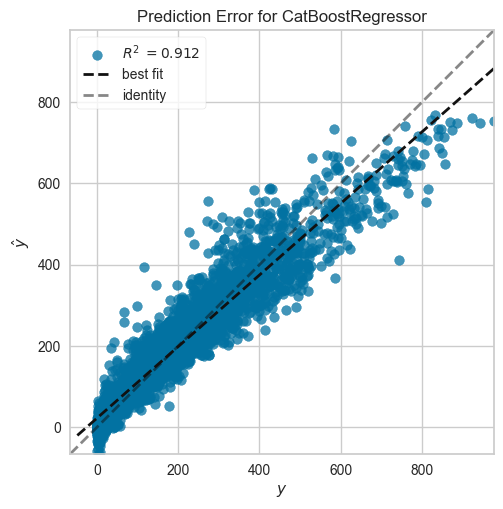

In [59]:
final_model = finalize_model(tuned_model)
save_model(final_model, 'cnt_model')
plot_model(final_model, plot='error')

In [60]:
pipeline = load_model(model_name="cnt_model")
prediction = predict_model(pipeline, data_prod)
prediction["prediction_label"] = prediction["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,cnt,prediction_label
16,1,16,0,6,0,2,0.42,0.82,0.2985,1,9.489166,93,158
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,28,54
57,1,12,0,1,1,1,0.22,0.35,0.2985,3,9.513333,61,83
60,1,15,0,1,1,1,0.26,0.30,0.2537,3,9.513333,72,78
70,1,1,0,2,1,1,0.16,0.59,0.1045,4,9.526667,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17322,1,15,0,6,0,2,0.24,0.87,0.0000,29,9.464723,129,146
17334,1,3,0,0,0,2,0.26,0.56,0.4179,30,9.473889,15,0
17343,1,12,0,0,0,1,0.28,0.36,0.5821,30,9.473889,144,167
17345,1,14,0,0,0,1,0.30,0.36,0.4627,30,9.473889,160,148


In [61]:
# Calculate Errors
actuals = data_prod['cnt'] 
predicted = prediction['prediction_label']  

r2 = r2_score(actuals, predicted)
print(f"R-squared: {r2}")

mae = mean_absolute_error(actuals, predicted)
print(f'MAE: {mae}')

mse = mean_squared_error(actuals, predicted)
rmse = sqrt(mse)
print(f"RMSE: {rmse}")

R-squared: 0.8953949822264303
MAE: 39.296892980437285
RMSE: 56.504091117400094


# Create model for casual

In [62]:
data_model_casual = bike_data.copy()
data_model_casual = data_model_casual.drop(columns=["cnt","registered"])
data_dev_casual = data_model_casual.loc[data_dev.index]
data_prod_casual = data_model_casual.loc[data_prod.index]

reg_setup_casual = setup(data_dev_casual, target= "casual", train_size= 0.8, session_id= 124, 
                    verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True,
                   )
best_model_casual = compare_models(sort="MAE", fold=5)
best_model_casual

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:45:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:47:30
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:47:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


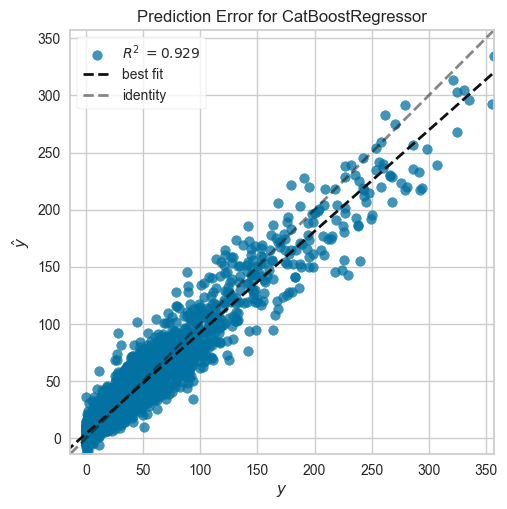

In [63]:
model_casual = create_model("catboost")
tuned_model_casual = tune_model(model_casual, optimize = "MAE", fold= 2, n_iter= 2)  
final_model_casual = finalize_model(tuned_model_casual)
save_model(final_model_casual, 'cnt_model_casual')
plot_model(final_model_casual, plot='error')

In [64]:
pipeline_casual = load_model(model_name="cnt_model_casual")
prediction_casual = predict_model(pipeline_casual, data_prod_casual)
prediction_casual["prediction_label"] = prediction_casual["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction_casual

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,casual,prediction_label
16,1,16,0,6,0,2,0.42,0.82,0.2985,1,9.489166,41,51
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,11,3
57,1,12,0,1,1,1,0.22,0.35,0.2985,3,9.513333,13,7
60,1,15,0,1,1,1,0.26,0.30,0.2537,3,9.513333,14,12
70,1,1,0,2,1,1,0.16,0.59,0.1045,4,9.526667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17322,1,15,0,6,0,2,0.24,0.87,0.0000,29,9.464723,19,28
17334,1,3,0,0,0,2,0.26,0.56,0.4179,30,9.473889,1,0
17343,1,12,0,0,0,1,0.28,0.36,0.5821,30,9.473889,47,30
17345,1,14,0,0,0,1,0.30,0.36,0.4627,30,9.473889,39,29


In [74]:
# Calculate Errors
actuals_casual = data_prod_casual['casual'] 
predicted_casual = prediction_casual['prediction_label']  

r2_casual = r2_score(actuals_casual, predicted_casual)
print(f"R-squared: {r2_casual}")

mae_casual = mean_absolute_error(actuals_casual, predicted_casual)
print(f'MAE: {mae_casual}')

mse_casual = mean_squared_error(actuals_casual, predicted_casual)
rmse_casual = sqrt(mse_casual)
print(f'RMSE: {rmse_casual}')

R-squared: 0.897917967937407
MAE: 9.535097813578826
RMSE: 15.523989379668778


# Predicted Registered

In [75]:
data_model_registered = bike_data.copy()
data_model_registered = data_model_registered.drop(columns=["cnt","casual"])
data_dev_registered = data_model_registered.loc[data_dev.index]
data_prod_registered = data_model_registered.loc[data_prod.index]

reg_setup_registered = setup(data_dev_registered, target= "registered", train_size= 0.8,
                    session_id= 125, 
                    verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True
                   )
best_model_registered = compare_models(sort="MAE", fold=5)
best_model_registered

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:48:48
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:50:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:50:43
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


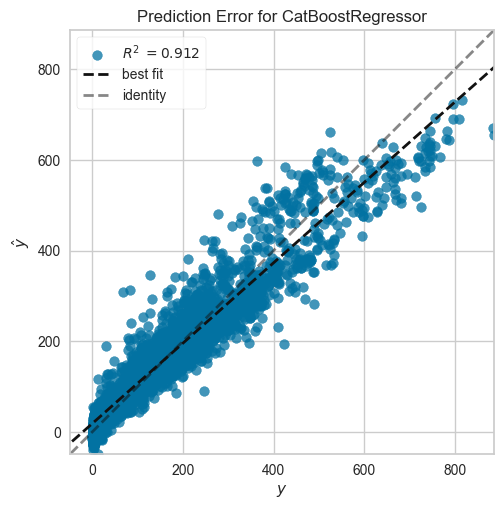

In [76]:
model_registered = create_model("catboost")
tuned_model_registered = tune_model(model_registered, optimize = "MAE", fold= 2, n_iter= 2)  
final_model_registered = finalize_model(tuned_model_registered)
save_model(final_model_registered, 'cnt_model_registered')
plot_model(final_model_registered, plot='error')

In [77]:
pipeline_registered = load_model(model_name="cnt_model_registered")
prediction_registered = predict_model(pipeline_registered, data_prod_registered)
prediction_registered["prediction_label"] = prediction_registered["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction_registered

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,registered,prediction_label
16,1,16,0,6,0,2,0.42,0.82,0.2985,1,9.489166,52,133
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,17,44
57,1,12,0,1,1,1,0.22,0.35,0.2985,3,9.513333,48,77
60,1,15,0,1,1,1,0.26,0.30,0.2537,3,9.513333,58,73
70,1,1,0,2,1,1,0.16,0.59,0.1045,4,9.526667,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17322,1,15,0,6,0,2,0.24,0.87,0.0000,29,9.464723,110,107
17334,1,3,0,0,0,2,0.26,0.56,0.4179,30,9.473889,14,0
17343,1,12,0,0,0,1,0.28,0.36,0.5821,30,9.473889,97,131
17345,1,14,0,0,0,1,0.30,0.36,0.4627,30,9.473889,121,111


In [80]:
# Calculate Errors
actuals_registered = data_prod_registered['registered'] 
predicted_registered = prediction_registered['prediction_label']  


r2_registered = r2_score(actuals_registered, predicted_registered)
print(f"R-squared: {r2_registered}")

mae_registered = mean_absolute_error(actuals_registered, predicted_registered)
print(f'MAE: {mae_registered}')

mse_registered = mean_squared_error(actuals_registered, predicted_registered)
rmse_registered = sqrt(mse_registered)
print(f'RMSE: {rmse_registered}')

R-squared: 0.8854983366142263
MAE: 32.92865362485615
RMSE: 48.718975256644484


# Compound to Actual

In [83]:
# Calculate Errors
actuals_cnt = data_prod['cnt'] 
predicted_compound = prediction_casual['prediction_label']   + prediction_registered['prediction_label']  

r2_compound = r2_score(actuals_cnt, predicted_compound)
print(f"R-squared: {r2_compound}")

mae_compound = mean_absolute_error(actuals_cnt, predicted_compound)
print(f'MAE: {mae_compound}')

mse_compound = mean_squared_error(actuals_cnt, predicted_compound)
rmse_compound = sqrt(mse_compound)
print(f'RMSE: {rmse_compound}')

R-squared: 0.8928679181376193
MAE: 39.43037974683544
RMSE: 57.18253533663834


# Compound to General Model

In [87]:
# Calculate Errors
actuals_cnt = prediction['prediction_label'] 
predicted_compound = prediction_casual['prediction_label']   + prediction_registered['prediction_label']  

r2_compound = r2_score(actuals_cnt, predicted_compound)
print(f"R-squared: {r2_compound}")

mae_compound = mean_absolute_error(actuals_cnt, predicted_compound)
print(f'MAE: {mae_compound}')

mse_compound = mean_squared_error(actuals_cnt, predicted_compound)
rmse_compound = sqrt(mse_compound)
print(f'RMSE: {rmse_compound}')

R-squared: 0.9957379837920158
MAE: 7.666283084004603
RMSE: 10.39130822063558


# Conclusions
- Pycaret is using in 2023 by international community: https://ieeexplore.ieee.org/document/10101357, https://ieeexplore.ieee.org/document/10100285, https://ieeexplore.ieee.org/document/10183591
- polynomial_features and pca does not reduce significant the error
- solar light has a low reduction of error
- We choose R2, MAE and RMSE because was choosen in similar works: https://www.sciencedirect.com/science/article/abs/pii/S0140366419318997, https://link.springer.com/chapter/10.1007/978-3-030-94751-4_25, https://arxiv.org/pdf/2108.00858.pdf 
- Further research about integrate external data

## PART III: Streamlit dashboard

In [ ]:
### This part goes in a separate script ###